# PAIRS TRADING AND COINTEGRATION STRATEGY

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

!pip install yfinance
!pip install niftystocks
!pip install quantstats

from itertools import permutations
from niftystocks import ns
import statsmodels.api as sm
import quantstats as qs
import yfinance as yf
from statsmodels.tsa.stattools import coint
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.stattools import adfuller
import yfinance.shared as shared

from scipy.stats import zscore
import tabulate

import warnings
warnings.filterwarnings("ignore")

In [69]:
!pip install --upgrade yfinance

# Fetching stock price data


In [70]:
# Considering top 12 stocks of energy sector
stocks = [
    'XOM', 'CVX', 'COP', 'EOG', 'SLB', 'PSX',
    'MPC', 'VLO', 'HAL', 'BKR', 'HES', 'DVN'
]
stock_data =  yf.download(stocks, start = "2019-04-01" ,end= "2022-03-31")['Close']
stock_data

[*********************100%***********************]  12 of 12 completed


Ticker,BKR,COP,CVX,DVN,EOG,HAL,HES,MPC,PSX,SLB,VLO,XOM
Date,,,,,,,,,,,,
2019-04-01,23.168695,54.810402,96.031143,23.130587,74.512817,26.887054,55.602829,49.953281,74.282402,38.114811,67.106171,61.328659
2019-04-02,22.461319,53.725361,96.023438,22.888569,73.828697,26.708639,55.155003,49.028671,73.852638,37.884884,65.568848,61.066021
2019-04-03,22.028563,53.045200,95.224075,22.521885,72.199181,26.699717,54.433014,49.405060,74.258934,37.118511,65.421326,60.705853
2019-04-04,22.278231,52.761791,95.923515,22.741892,71.999336,27.136831,55.520576,50.198746,75.680992,37.552799,65.491196,61.568768
2019-04-05,22.286558,53.539131,97.168678,23.614609,75.811829,27.627478,57.576893,51.933403,76.407654,38.319176,67.308022,61.898956
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-24,35.348019,93.106735,147.983566,52.336735,104.131546,35.622231,102.547508,76.080849,72.628181,40.052547,87.861824,75.151817
2022-03-25,35.744980,95.743011,150.662079,53.153172,107.143379,36.775600,105.021904,76.866066,75.072380,41.029434,88.599770,76.792213
2022-03-28,34.157127,92.180481,148.028076,51.409740,104.002480,35.281887,103.423645,76.623016,73.675705,39.197765,87.798050,74.638062


# Two-step Engle & Granger test for cointegration

In [71]:
def perform_regression(y, x):
    # Ensure inputs are 1D arrays or Series
    y = np.asarray(y).flatten()
    x = np.asarray(x).flatten()

    # Add intercept to x
    X = add_constant(x)  # adds a column of 1s for intercept

    # Fit OLS regression
    model = OLS(y, X).fit()

    # Extract parameters and residuals
    c, gamma = model.params
    residuals = model.resid

    return c, gamma, residuals

In [72]:
def test_stationarity(y, x):
    # Calculate the spread using the regression
    c, gamma, z = perform_regression(y, x)

    # Perform Augmented Dickey-Fuller test with fixed lag=1
    adfstat, pvalue, usedlag, nobs, crit_values = adfuller(z, maxlag=1, autolag=None)

    return adfstat, pvalue

# Finding p value and testing cointegration for each pair of stock

In [73]:
def test_stock_cointegration(stock_data, stocks):
    data = {
        'Pairs': [],
        'Constant': [],
        'Gamma': [],
        'P-Value': []
    }
    zvalues = {}

    for stock1 in stocks:
        for stock2 in stocks:
            if stock1 == stock2:
                continue

            if stock_data[stock1].empty or stock_data[stock2].empty:
                print(f"Warning: Skipping pair ({stock1}, {stock2}) due to empty stock data.")
                continue

            # Perform cointegration analysis
            c, gamma, zvalue = perform_regression(
                np.log(stock_data[stock1]),
                np.log(stock_data[stock2])
            )
            t_stat, pvalue = test_stationarity(
                np.log(stock_data[stock1]),
                np.log(stock_data[stock2])
            )

            pair = (stock1, stock2)
            data['Pairs'].append(pair)
            data['Constant'].append(c)
            data['Gamma'].append(gamma)
            data['P-Value'].append(pvalue)
            zvalues[pair] = zvalue

    results_df = pd.DataFrame(
        data,
        index=pd.MultiIndex.from_tuples(data['Pairs'])
    )
    results_df.drop('Pairs', axis=1, inplace=True)

    return results_df, pd.DataFrame(zvalues)

# Plotting p values

In [74]:
def plot_pvalues(coint_data):
    coint_mat = coint_data.unstack(level=0)['P-Value']
    coint_mat = coint_mat.fillna(1)
    plt.figure(figsize=(12, 8))
    sns.heatmap(coint_mat, annot=True, cmap="YlOrRd")
    plt.title("Heatmap of Pairs")
    plt.show()

         Constant     Gamma   P-Value
XOM CVX -1.820275  1.272474  0.144926
    COP  0.768215  0.806514  0.205405
    EOG  0.834899  0.752500  0.001564
    SLB  1.316839  0.782570  0.075465
    PSX -0.471534  1.031697  0.610090
...           ...       ...       ...
DVN MPC -3.224578  1.602557  0.020307
    VLO -5.106109  1.947414  0.150622
    HAL -1.225032  1.406130  0.316763
    BKR -3.025720  2.009710  0.017223
    HES -4.844152  1.885250  0.033294

[132 rows x 3 columns]


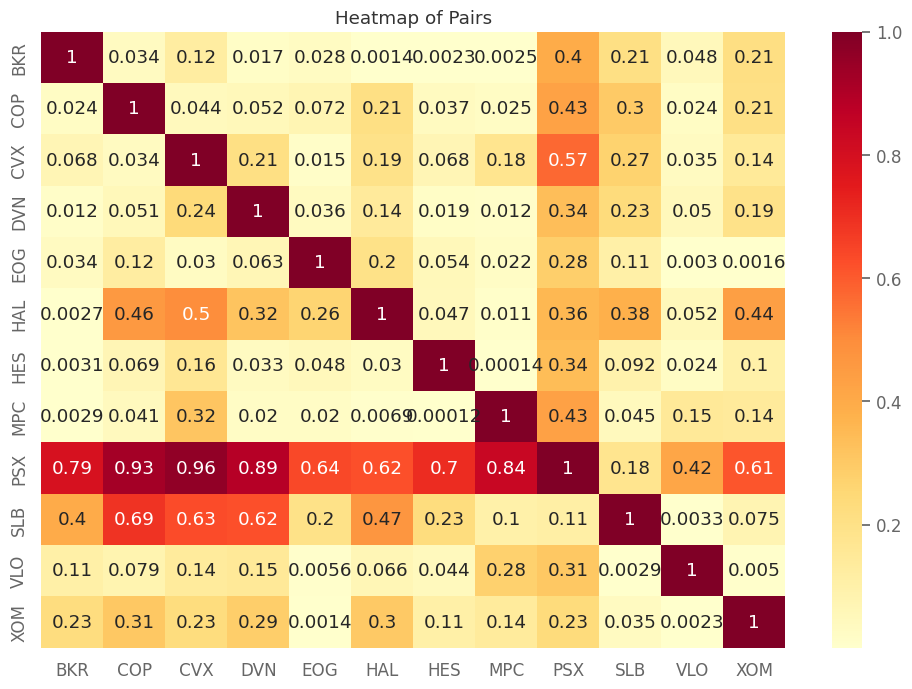

In [76]:
coint_analysis,zvalues = test_stock_cointegration(stock_data,stocks)
print(coint_analysis)
plot_pvalues(coint_analysis)

# Selecting stock pair for pairs trading

In [78]:
tradable_pairs = coint_analysis[coint_analysis['P-Value'] < 0.005].sort_values('P-Value')
tradable_pairs

Constant     Gamma   P-Value
HES MPC  1.034171  0.803725  0.000123
MPC HES -0.796306  1.123771  0.000141
EOG XOM -0.873193  1.267500  0.001366
HAL BKR -0.894380  1.296757  0.001380
XOM EOG  0.834899  0.752500  0.001564
VLO XOM  0.792146  0.853431  0.002295
HES BKR  1.247553  0.968936  0.002319
MPC BKR  0.333629  1.182182  0.002536
BKR HAL  0.922507  0.690480  0.002666
    MPC  0.078135  0.750556  0.002891
SLB VLO -1.781433  1.230565  0.002913
VLO EOG  1.523365  0.637540  0.002965
BKR HES -0.587447  0.860130  0.003079
VLO SLB  1.840483  0.691206  0.003285
XOM VLO -0.291405  1.015535  0.004974

In [79]:
def select_stock_pair(stock_data, S1, S2):

    # Plot log prices of both stocks
    plt.figure(figsize=(20, 5))
    plt.plot(np.log(stock_data[S1]), color="blue", label=S1)
    plt.plot(np.log(stock_data[S2]), color="red", label=S2)
    plt.title(f'Log Prices: {S1} vs {S2}')
    plt.xlabel('Time')
    plt.ylabel("Log Price")
    plt.legend()
    plt.show()

    # Perform regression to get cointegration parameters
    c, gamma, zvalue = perform_regression(np.log(stock_data[S1]), np.log(stock_data[S2]))

    # Convert zvalue to a Pandas Series for plotting
    zvalue_series = pd.Series(zvalue, index=stock_data.index)

    # Plot the spread (error-correction term)
    plt.figure(figsize=(20, 5))
    plt.title(f'Error-correction term (Spread) between {S1} and {S2}')
    zvalue_series.plot()
    plt.xlabel('Time')
    plt.ylabel('Magnitude')
    plt.grid(color='gray', linestyle='--', linewidth=0.7)
    plt.axhline(0.05, color='g', linestyle='--')    # Upper threshold
    plt.axhline(0, color='black', linestyle='-')    # Zero line
    plt.axhline(-0.05, color='r', linestyle='--')   # Lower threshold
    plt.legend(['Z-Value', 'Positive Threshold', 'Zero', 'Negative Threshold'], loc='lower left')
    plt.show()

    return zvalue_series, gamma

# Z SCORE

In [81]:
def zscore(series, window_length=20):

    # Handle edge case where series is shorter than window
    if len(series) <= window_length:
        return pd.Series([], index=series.index[0:0])

    # Calculate rolling mean and standard deviation
    rolling_mean = series.rolling(window=window_length).mean()
    rolling_std = series.rolling(window=window_length).std()

    # Calculate z-scores using vectorized operations
    z_scores = (series - rolling_mean) / rolling_std

    return z_scores.iloc[window_length:]

# Trading Stratergy

In [82]:
def strategy(S1, S2, threshold=1, stop_loss=0.5):

    strat = yf.download([S1, S2], start="2022-04-01", end="2025-03-31")['Close']

    gamma = select_stock_pair(stock_data, S1, S2)[1]

    # Calculate spread and z-score
    spread = np.log(strat[S1]) - gamma * np.log(strat[S2])
    strat['zscore'] = zscore(spread)

    # Generate trading signals
    strat['signal'] = np.select(
        [strat['zscore'] > threshold, strat['zscore'] < -threshold],
        [1, -1],
        default=0
    )

    # Apply stop loss
    strat.loc[abs(strat["zscore"]) > threshold + stop_loss, "signal"] = 0

    # Apply take profit
    strat.loc[abs(strat["zscore"]) == 0, "signal"] = 0

    # Generate positions for each stock
    strat['position1'] = -strat['signal'].diff()
    strat['position2'] = -strat['position1']
    strat = strat.fillna(0)

    return strat, gamma

# Visualizing Signal Generation

In [83]:
def visualize_strategy(strat):
    fig, axs = plt.subplots(3, sharex=True, figsize=(15,12))
    axs[0].set_title('Market Value')
    axs[0].plot(strat[S1],label=S1,color='black')
    axs[0].plot(strat[S1][strat['position1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)
    axs[0].plot(strat[S1][strat['position1'] == -1], lw=0, marker='^', markersize=8, c='r',alpha=0.7)
    axs[0].grid(color='gray', linestyle='--', linewidth=0.7)
    axs[0].legend()
    axs[1].set_title('Market Value')
    axs[1].plot(strat[S2],label=S2,color='black')
    axs[1].plot(strat[S2][strat['position2'] == -1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)
    axs[1].plot(strat[S2][strat['position2'] == 1], lw=0, marker='^', markersize=8, c='r',alpha=0.7)
    axs[1].grid(color='gray', linestyle='--', linewidth=0.7)
    axs[1].legend()
    axs[2].set_title('Zscore')
    axs[2].plot(strat['zscore'])
    axs[2].grid(color='gray', linestyle='--', linewidth=0.7)
    axs[2].axhline(1.5,color='r')
    axs[2].axhline(1,color='g')
    axs[2].axhline(0,color='black')
    axs[2].axhline(-1,color='g')
    axs[2].axhline(-1.5,color='r')
    axs[2].fill_between(strat.index,strat.zscore,1,where = strat.zscore >= 1, color = 'lightcoral')
    axs[2].fill_between(strat.index,strat.zscore,-1,where = strat.zscore <= -1, color = 'lightgreen')
    plt.show()

# PnL Calculation

In [84]:
def pnl(strategy):

    initial_capital = 100000

    # Dividing capital in ratio gamma:1
    C2 = initial_capital/(1+gamma)
    C1 = gamma*C2

    # Shares to buy for each stock
    shares1 = C1 // (strategy[S1][0])
    shares2 = C2 // (strategy[S2][0])

    portfolio = pd.DataFrame()

    # PnL for stock 1
    portfolio['return1'] = strat[S1].pct_change()*strat['signal']*shares1*100
    portfolio['total1'] = C1 + portfolio['return1'].cumsum()

    # PnL for stock 2
    portfolio['return2'] = -strat[S2].pct_change()*strat['signal']*shares2*100
    portfolio['total2'] = C2 + portfolio['return2'].cumsum()

    # Total PnL
    portfolio['total'] = portfolio['total1'] + portfolio['total2']
    portfolio = portfolio.dropna()

    return portfolio

# Visualizing Portfolio

In [85]:
def visualize_portfolio_pnl(strategy):
    pft = pnl(strategy)
    # Plot portfolio value
    plt.figure(figsize=(20,5))
    plt.grid(color='gray', linestyle='--', linewidth=0.7)
    plt.title("Portfolio Value")
    plt.plot(pft['total'], color='red')
    plt.show()

    # Plot daily PnL
    plt.figure(figsize=(20, 5))
    plt.grid(color='gray', linestyle='--', linewidth=0.7)
    plt.title("Daily PNL")
    plt.plot(100 * pft['total'].pct_change(), color='red')
    plt.show()

# Stratergy Metrics

In [86]:
def metrics(strategy):
    pft = pnl(strategy)
    # Profit (Cumulative return)
    cumulative_return = (pft['total'].iloc[-1] / pft['total'].iloc[0]) - 1

    # CAGR
    CAGR = (pft['total'].iloc[-1] / pft['total'].iloc[0])**(252 / len(pft)) - 1

    # Sharpe Ratio
    risk_free_rate = 0.01
    daily_returns = pft['total'].pct_change()
    excess_daily_returns = 100 * daily_returns - risk_free_rate
    sharpe = np.sqrt(252) * excess_daily_returns.mean() / excess_daily_returns.std()

    # Maximum Drawdown
    rolling_max = pft['total'].expanding().max()
    drawdown = 100 * (rolling_max - pft['total']) / rolling_max
    max_drawdown = drawdown.max()

    # Trade count
    trade_count = np.count_nonzero(strategy['position1'])

    print(f"Profit (Cumulative Return): {cumulative_return * 100:.2f}%")
    print(f"CAGR: {CAGR * 100:.2f}%")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2f}%")
    print(f"Trades Taken: {trade_count}")


[*********************100%***********************]  2 of 2 completed


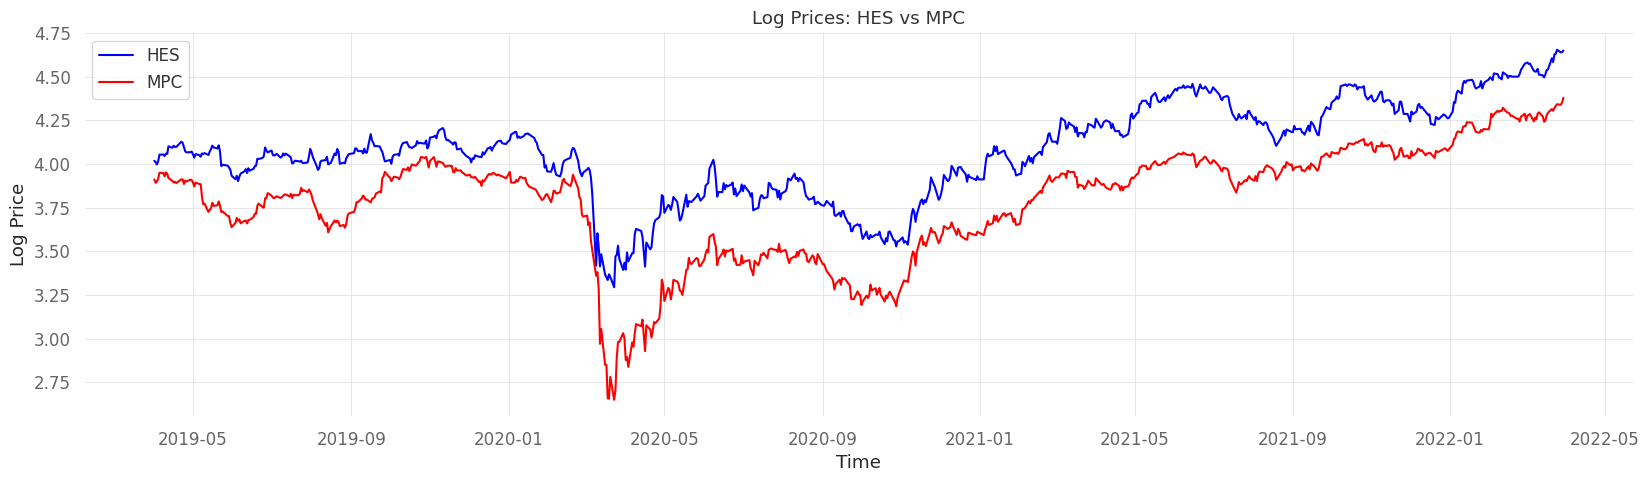

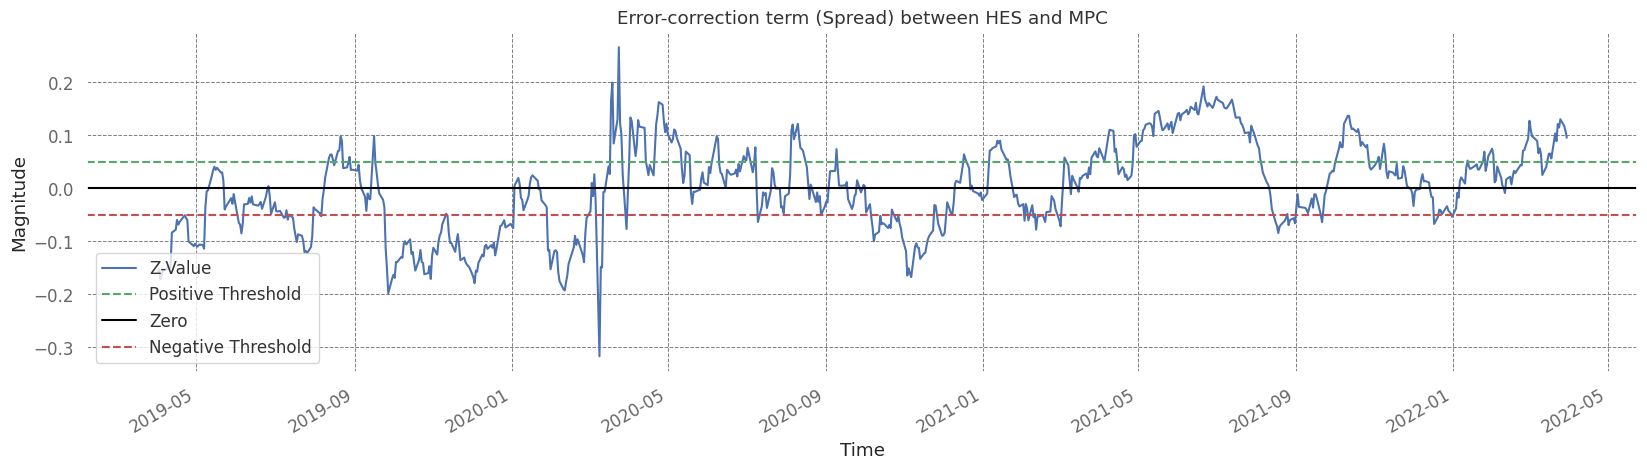

In [87]:
S1 = tradable_pairs.index[0][0]  # First stock in Pair 1 from tradable pair
S2 = tradable_pairs.index[0][1]  # Second stock in Pair 1 from tradable pair
#S1 = 'HES'
#S2 = 'MPC'
strat, gamma = strategy(S1,S2,1,1)

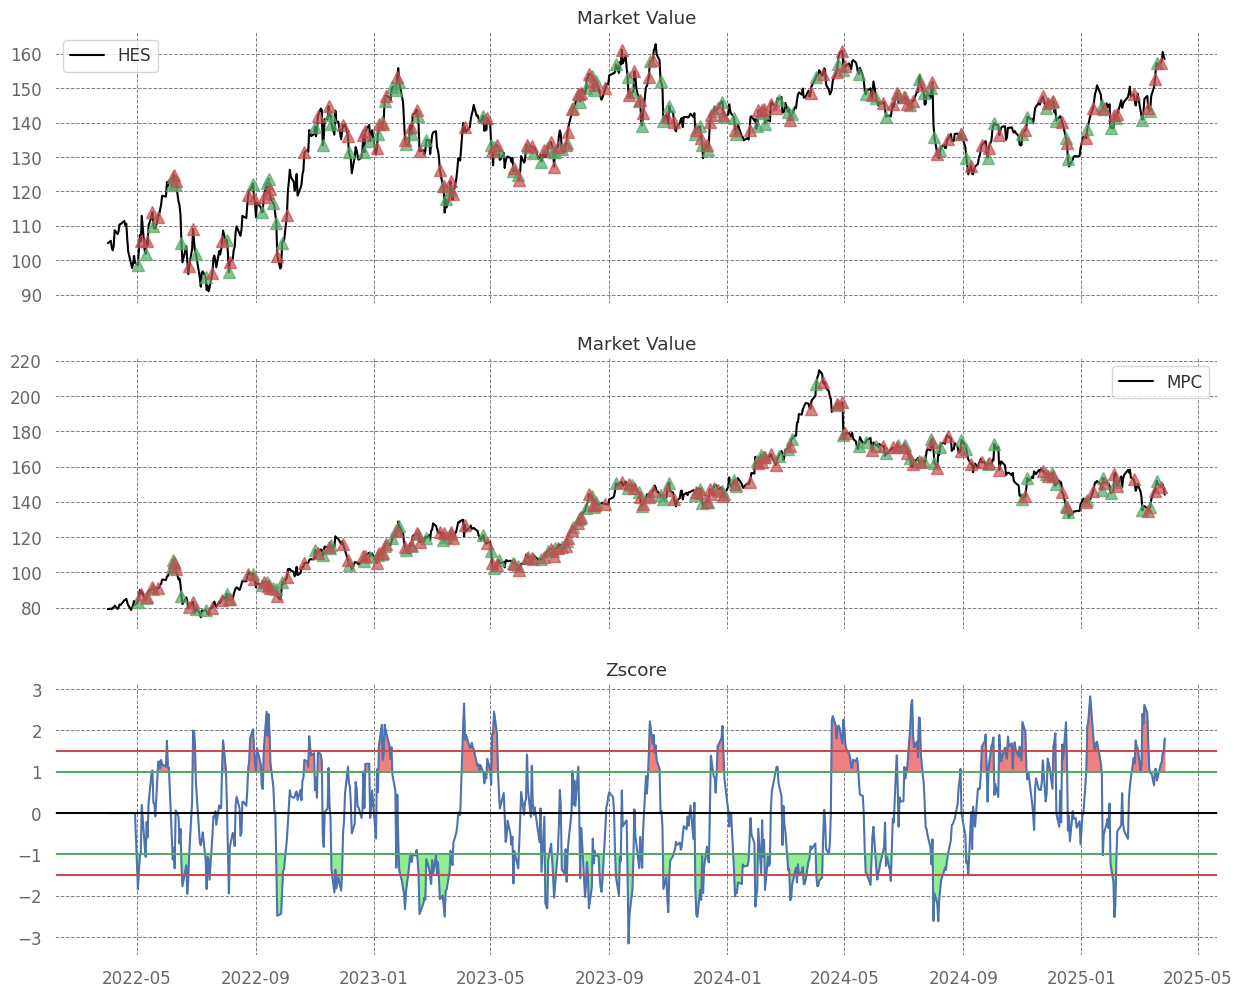

In [88]:
visualize_strategy(strat)

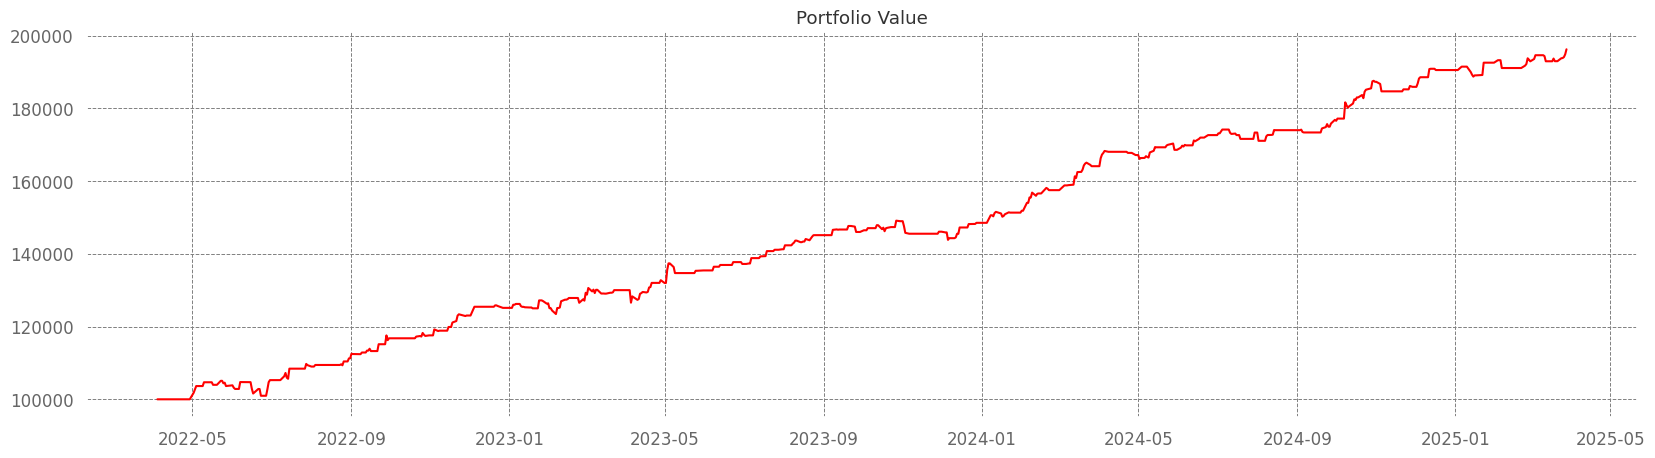

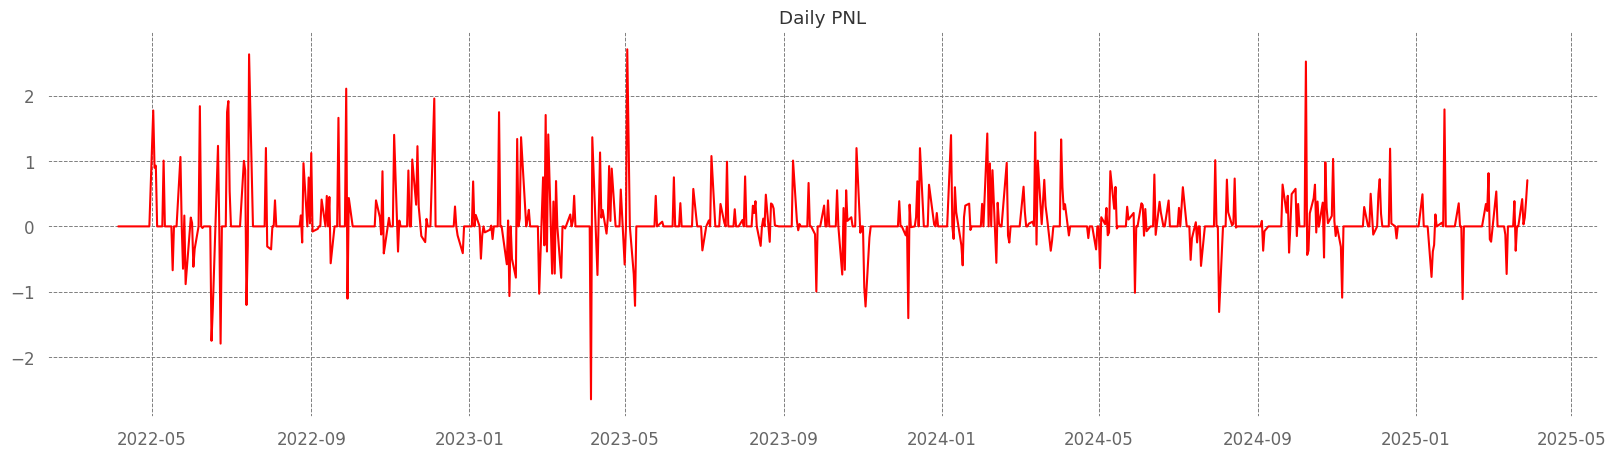

In [89]:
visualize_portfolio_pnl(strat)

In [90]:
metrics(strat)

Profit (Cumulative Return): 96.21%
CAGR: 25.46%
Sharpe Ratio: 2.71
Maximum Drawdown: 3.91%
Trades Taken: 237
